In [3]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import math

In [4]:
#Defining our global variables:
N_nodes = 100

In [10]:
#Defining graph
G=nx.DiGraph()
G.add_nodes_from(range(N_nodes))

In [13]:
#Defining attributes
for i in range(N_nodes):
    G.node[i]['X'] = random.random()
    G.node[i]['Z'] = random.random()

In [21]:
#Creating similarity matrix
similarity_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
similarity_coefficient = 3
for i in range(N_nodes):
    for j in range(i):
        similarity_matrix[i][j] = -similarity_coefficient*math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2 + (G.node[i]['Z'] - G.node[j]['Z'])**2)
        similarity_matrix[j][i] = similarity_matrix[i][j]

In [ ]:
def run_step(Graph):
    for i in range(N_nodes):
        

In [ ]:
#For each step, build fixed point algorithm, should converge pretty fast.
#Think about best convergence, not go through the nodes in the same way at each step

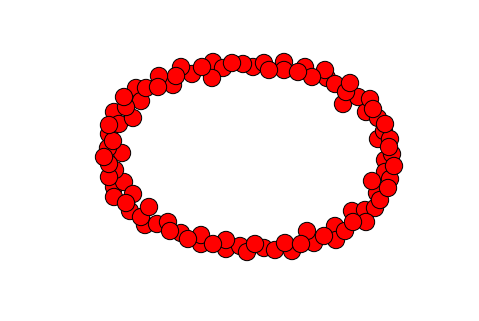

In [6]:
#Plotting the last graph obtained
nx.draw(G)
plt.show()